# Lasy losowe
Łukasz Klimkiewicz, 244822

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Numer indeksu
index = 244822

In [3]:
# Wartości pochodne
seed = index
n_samples = int(str(index)[0:2] + str(index)[-2:])
print(f'seed: {seed}; samples: {n_samples}')

seed: 244822; samples: 2422


## Implementacja lasu losowego

In [4]:
class Tree:
    
    def __init__(self, classifier, X, y, depth=0):
        assert y.size > 0
        self.classifier = classifier
        self.X = X
        self.y = y
        self.depth = depth
        
        self.samples = X.shape[0]
        self.values = self._get_values(y)
        self.class_ = np.argmax(self.values)
        self.gini = self._calc_gini(y)
        
        self.feature = None
        self.treshold = None
        
        self.left = None
        self.right = None
        
    @staticmethod
    def _get_values(y):
        count_0 = np.sum(y == 0)
        count_1 = np.sum(y == 1)
        return np.array([count_0, count_1])
    
    @classmethod
    def _calc_gini(cls, y):
        if y.size == 0:
            return 0
        values = cls._get_values(y)
        p = values / np.sum(values)
        p_square_sum = np.sum(p*p)
        G = 1 - p_square_sum
        return G
    
    @property
    def _decision_node(self):
        return self.left is not None
    
    def _get_proper_subtree(self, x):
        res = np.less_equal(x[self.feature], self.treshold)
        subtree = self.left if res else self.right
        return subtree
    
    def expand_recursively(self, max_depth=None):
        nodes = [self]
        while nodes:
            node = nodes.pop(0)
            
            if max_depth and node.depth >= max_depth or node.samples <= 1 or node.gini == 0:
                continue
                
            childs = node._expand()
            nodes.extend(childs)
    
    def _expand(self):
        assert not self._decision_node, 'Node is already expanded'
        assert self.samples > 1
        feature, treshold = self._get_best_split_feature_and_treshold()
        new_nodes = self._split(feature, treshold)
        return new_nodes
    
    def _get_best_split_feature_and_treshold(self):
        features = self._get_considered_features()
        tresholds_and_gains = np.array([self._get_best_split_treshold(feature) for feature in features])
        tresholds = tresholds_and_gains[:, 0]
        gains = tresholds_and_gains[:, 1]
        best_index = np.argmax(gains)
        return features[best_index], tresholds[best_index]
    
    def _get_considered_features(self):
        n_features_total = self.X.shape[1]
        n_features_limit = self.classifier._max_features_exact
        features = np.arange(n_features_total)
        np.random.shuffle(features)
        considered_features = features[:n_features_limit]
        return considered_features
    
    def _get_best_split_treshold(self, feature):
        tresholds = self._get_possible_tresholds(feature)
        gains = np.array([self._get_split_gain(feature, treshold) for treshold in tresholds])
        best_index = np.argmax(gains)
        return tresholds[best_index], gains[best_index]
    
    def _get_possible_tresholds(self, feature):
        feature_values = self.X[:, feature]
        if feature_values.size > self.classifier.resolution:
            percentiles = np.linspace(0, 100, self.classifier.resolution, endpoint=False)
            return np.unique(np.percentile(feature_values, percentiles))
        else:
            tresholds = []
            for val, next_val in zip(feature_values, feature_values[1:]):
                center_val = (val + next_val) / 2
                tresholds.append(center_val)
            return np.unique(np.array(tresholds))
    
    def _get_split_gain(self, feature, treshold):
        op_filter = np.less_equal(self.X[:, feature], treshold)
        y1, y2 = self.y[op_filter], self.y[~op_filter]
        s1, s2 = y1.size, y2.size
        s = self.y.size
        e1, e2 = self._calc_gini(y1), self._calc_gini(y2)
        return self.gini - (s1/s*e1 + s2/s*e2)
    
    def _split(self, feature, treshold):
        assert self.samples >= 0
        op_result = np.less_equal(self.X[:, feature], treshold)
        count_0 = np.sum(op_result == 0)
        count_1 = np.sum(op_result == 1)
        # assert count_0 > 0 and count_1 > 0, f'{self.values} | {count_0} {count_1}, {self.X[:, feature]}'
        if count_0 == 0 or count_1 == 0:
            return []
        sorted_indexes = np.argsort(op_result)
        
        np.take(self.y, sorted_indexes, out=self.y)
        np.take(self.X, sorted_indexes, axis=0, out=self.X)
        
        lt = Tree(self.classifier, self.X[count_0:], self.y[count_0:], depth=self.depth+1)
        rt = Tree(self.classifier, self.X[:count_0], self.y[:count_0], depth=self.depth+1)
        
        self.left = lt
        self.right = rt
        self.feature = feature
        self.treshold = treshold
        
        return lt, rt
    
    def predict(self, X):
        predictions = np.array([self._predict_single(x) for x in X])
        return predictions
        
    def _predict_single(self, x):
        if self._decision_node:
            subtree = self._get_proper_subtree(x)
            return subtree._predict_single(x)
        else:
            return self.class_
        
    def predict_proba(self, X):
        predictions = np.array([self._predict_single(x) for x in X])
        return predictions
        
    def _predict_proba_single(self, x):
        if self._decision_node:
            subtree = self._get_proper_subtree(x)
            return subtree._predict_proba_single(x)
        else:
            return self.values / np.sum(self.values)

In [3]:
import math
import numba
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from scipy.sparse import issparse
from scipy import stats


class CustomRandomForestClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, n_estimators=30, max_depth=3, max_samples=1.0, max_features='auto', resolution=100,
                oob_score=f1_score, stop_iters=10, stop_diff=0.01):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_samples = max_samples
        self.max_features = max_features
        self.resolution = resolution
        self.oob_score = oob_score
        self.stop_iters = stop_iters
        self.stop_diff = stop_diff
        
        self._trees = None
        self._oob_predicitons = None
        self._oob_scores = None

    def fit(self, X, y):        
        # prepare inputs
        y = y.flatten()
        if issparse(X):
            X = X.A
            
        X = X.copy()
        y = y.copy()
        
        # Initialize state
        self._max_features_exact = self._get_max_features_exact(X)
        self._trees = []
        self._oob_predictions = [[] for i in range(X.shape[0])]
        self._oob_scores = []
        
        # plant trees
        while self._should_plant_next_tree():
            self._plant_tree(X, y)

        return self
    
    def _should_plant_next_tree(self):
        if self.n_estimators == 'auto':
            if len(self._trees) <= self.stop_iters:
                return True
            past_score = np.max(self._oob_scores[:-self.stop_iters])
            curr_score = self._oob_scores[-1]
            return curr_score - past_score > self.stop_diff
        else:
            return len(self._trees) < self.n_estimators
    
    def _get_max_features_exact(self, X):
        if self.max_features == 'auto':
            return math.floor(math.sqrt(X.shape[1]))
        elif self.max_features is None:
            return X.shape[0]
        else:
            return self.max_features
        
    def _get_max_samples_exact(self, X):
        if self.max_samples is None:
            return X.shape[0]
        elif isinstance(self.max_samples, float):
            return math.floor(self.max_samples * X.shape[0])
        else:
            return self.max_samples
    
    def _plant_tree(self, X, y):
        # bagging
        selected, not_selected = self._bagging(X, y)
        Xb, yb = X[selected], y[selected]
        x_oob, y_oob = X[not_selected], y[not_selected]
        
        # creating tree
        tree = Tree(self, Xb, yb)
        tree.expand_recursively(max_depth=self.max_depth)
        self._trees.append(tree)
        
        # oob stuff
        if self.oob_score is not None:
            pred_oob = tree.predict(x_oob)
            for i, pred in zip(not_selected, pred_oob):
                self._oob_predictions[i].append(pred)
            oob_score = self._calc_oob_score(y)
            self._oob_scores.append(oob_score)
        
    def _calc_oob_score(self, ys_true):
        final_predictions = []
        for y_true, ys_pred in zip(ys_true, self._oob_predictions):
            final_predictions.append(stats.mode(ys_pred)[0][0] if len(ys_pred) > 0 else 1 - y_true)
        final_predictions = np.array(final_predictions)
        return self.oob_score(ys_true, final_predictions)
    
    def _bagging(self, X, y):
        count = self._get_max_samples_exact(X)
        all_rows = np.arange(X.shape[0])
        selected = np.random.choice(all_rows, size=(count,))
        not_selected = np.array(list(set(all_rows) - set(selected)))
        return selected, not_selected
    
    def predict(self, X):
        if self._trees is None:
            raise ValueError('Model is not fitted')
        votes = np.array([tree.predict(X) for tree in self._trees])
        most_common = stats.mode(votes, axis=0)[0].flatten()
        return most_common
    
    def predict_proba(self, X):
        if self._trees is None:
            raise ValueError('Model is not fitted')
        votes = np.array([tree.predict(X) for tree in self._trees])
        one_votes = np.sum(votes == 1, axis=0)
        zero_votes = np.sum(votes == 0, axis=0)
        proba = np.column_stack([zero_votes, one_votes]) / votes.shape[1]
        return proba

## Funkcje pomocnicze

In [6]:
def plot_classifier(classifier, X, y, *, ax, margin=0.2, resolution=100, 
                    title='Powierzchnia decyzyjna', xl='Cecha 1', yl='Cecha 2'):
    
    data = {'x': X, 'y': y}

    x1 = data['x'][:,0].min() - margin
    x2 = data['x'][:,0].max() + margin
    y1 = data['x'][:,1].min() - margin
    y2 = data['x'][:,1].max() + margin

    space_syn1 = np.meshgrid(np.linspace(x1, x2, resolution), np.linspace(y1, y2, resolution))
    predictions_syn1 = classifier.predict(np.dstack([*space_syn1]).reshape(-1, 2)).reshape(resolution, resolution)

    ax.contourf(space_syn1[0], space_syn1[1], predictions_syn1, alpha=0.2)
    ax.scatter(data['x'][:,0], data['x'][:,1], c=data['y']);

    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    ax.set_title(title);
    ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
    ax.grid()

In [7]:
from sklearn.base import clone
import timeit

def measure_models_times(models, data, n_fit=10, n_predict=100):
    records = []
    
    for name, model in models.items():
        cloned_model = clone(model)

        def time_fit():
            cloned_model.fit(data['train']['x'], data['train']['y'])

        def time_predict():
            cloned_model.predict(data['test']['x'])

        fit_time = timeit.timeit(time_fit, number=n_fit) / n_fit
        predict_time = timeit.timeit(time_predict, number=n_predict) / n_predict

        record = (name, fit_time, predict_time)
        records.append(record)
        
    matrix = np.array(records)

    df = pd.DataFrame({
        'Name': matrix[:,0],
        'Fit time': matrix[:,1],
        'Predict time': matrix[:,2],
    })
    
    df = df.set_index(['Name']).sort_index().rename_axis(index=None)
    return df

## Część I

### Generowanie danych

In [8]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier

# Generowanie
syn1_x, syn1_y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0, 
                                     n_repeated=0, n_clusters_per_class=1, random_state=seed, class_sep=1)

# Podział na zbiory
syn1_train_x, syn1_test_x, syn1_train_y, syn1_test_y = train_test_split(
    syn1_x, syn1_y, test_size=.2, random_state=seed, stratify=syn1_y)

# Strukturyzacja
syn1_data = {
    'train': {
        'x': syn1_train_x,
        'y': syn1_train_y
    },
    'test': {
        'x': syn1_test_x,
        'y': syn1_test_y
    }
}

In [9]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Generowanie
syn2_x, syn2_y = make_moons(n_samples=n_samples, noise=0.1, random_state=seed)

# Podział na zbiory
syn2_train_x, syn2_test_x, syn2_train_y, syn2_test_y = train_test_split(syn2_x, syn2_y, test_size=.2, random_state=seed)

# Strukturyzacja
syn2_data = {
    'train': {
        'x': syn2_train_x,
        'y': syn2_train_y,
    },
    'test': {
        'x': syn2_test_x,
        'y': syn2_test_y,
    }
}

In [10]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier

# Generowanie
syn3_x, syn3_y = make_classification(n_samples=n_samples, n_features=4, n_informative=4, n_redundant=0, 
                                     n_repeated=0, n_clusters_per_class=5, random_state=seed,
                                     class_sep=13, hypercube=False)

syn3_x = syn3_x[:, :2]

# Podział na zbiory
syn3_train_x, syn3_test_x, syn3_train_y, syn3_test_y = train_test_split(
    syn3_x, syn3_y, test_size=.2, random_state=seed, stratify=syn3_y)

# Strukturyzacja
syn3_data = {
    'train': {
        'x': syn3_train_x,
        'y': syn3_train_y
    },
    'test': {
        'x': syn3_test_x,
        'y': syn3_test_y
    }
}

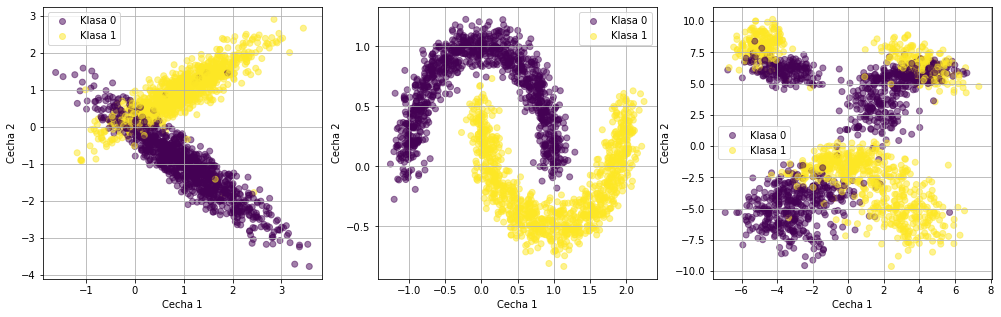

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(17, 5))

for ax, data in zip(axs, [syn1_data, syn2_data, syn3_data]):
    scatter = ax.scatter(data['train']['x'][:,0], data['train']['x'][:,1], c=data['train']['y'], alpha=0.5)
    ax.set_xlabel('Cecha 1')
    ax.set_ylabel('Cecha 2')
    ax.legend(*scatter.legend_elements(fmt="Klasa {x:n}"))
    ax.grid()

### Funkcje pomocnicze

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

def train_classifiers(data, max_depth=None, max_samples=None, resolution=100):

    custom_model = CustomRandomForestClassifier(n_estimators='auto', max_depth=max_depth, max_samples=max_samples, resolution=resolution)
    custom_model.fit(data['train']['x'], data['train']['y'])
    
    n_estimators = len(custom_model._trees)
    scikit_model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_samples=max_samples)
    
    scikit_model.fit(data['train']['x'], data['train']['y'])

    models = [custom_model, scikit_model]
    return models

In [13]:
def plot_classifiers(models, data):    
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    plot_classifier(models[0], data['x'], data['y'], ax=axs[0], title='Custom', xl=None, yl=None)
    plot_classifier(models[1], data['x'], data['y'], ax=axs[1], title='Scikit', xl=None, yl=None)

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrixes(models, data):
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))
    
    predictions_0 = models[0].predict(data['x'])
    predictions_1 = models[1].predict(data['x'])
        
    ConfusionMatrixDisplay.from_predictions(data['y'], predictions_0, ax=axs[0])
    ConfusionMatrixDisplay.from_predictions(data['y'], predictions_1, ax=axs[1])

    axs[0].set_title('Custom')
    axs[1].set_title('Scikit')
    
    fig.tight_layout()

In [15]:
from sklearn.metrics import recall_score, f1_score, accuracy_score

def show_models_metrics(models, data):
    records = []

    for method, model in zip(['custom', 'scikit'], models):

        predictions = model.predict(data['x'])

        sens = recall_score(data['y'], predictions)
        spec = recall_score(data['y'], predictions, pos_label=0)
        f1 = f1_score(data['y'], predictions)
        acc = accuracy_score(data['y'], predictions)

        record = (method, sens, spec, acc, f1)
        records.append(record)
            
    matrix = np.array(records)

    df = pd.DataFrame({
        'Method': matrix[:, 0],
        'Sensitivity': matrix[:, 1],
        'Specificity': matrix[:, 2],
        'Accuracy': matrix[:, 3],
        'F1': matrix[:, 4], 
    })
    
    df = df.set_index(['Method']).sort_index()
    return df

In [16]:
from sklearn.metrics import RocCurveDisplay

def show_roc_curves(models, data):
    fig, axs = plt.subplots(1, 2, figsize=(11, 4))
    
    for model, ax in zip(models, axs):
        tmp = model.predict_proba(data['x'])
        predictions = model.predict_proba(data['x'])[:, 1]
        RocCurveDisplay.from_predictions(data['y'], predictions, ax=ax)
        ax.grid()
        
    axs[0].set_title('Custom')
    axs[1].set_title('Scikit')
    fig.tight_layout()

In [17]:
def show_oob_scores(model):
    oob_scores = model._oob_scores
    fig, ax = plt.subplots(figsize=(14, 4))
    n_estimators = np.arange(1, len(oob_scores)+1)
    ax.plot(n_estimators, oob_scores)
    ax.set_title('Obb scores (F1)')
    ax.set_ylabel('F1 score')
    ax.set_xlabel('Number of trees')
    ax.grid()
    print(f'Final OOB Score: {oob_scores[-1]}')

In [18]:
from sklearn.base import clone
import timeit

def measure_times(models, data, n_fit=10, n_predict=100):
    records = []
    
    for method, model in zip(['custom', 'scikit'], models):
        cloned_model = clone(model)

        def time_fit():
            cloned_model.fit(data['train']['x'], data['train']['y'])

        def time_predict():
            cloned_model.predict(data['test']['x'])

        fit_time = timeit.timeit(time_fit, number=n_fit) / n_fit
        predict_time = timeit.timeit(time_predict, number=n_predict) / n_predict

        record = (method, fit_time, predict_time)
        records.append(record)
        
    matrix = np.array(records)

    df = pd.DataFrame({
        'Method': matrix[:,0],
        'Fit time': matrix[:,1],
        'Predict time': matrix[:,2],
    })
    
    df = df.set_index(['Method']).sort_index()
    return df

### a) Pierwszy zbiór jednomodowy

#### Nauka

In [233]:
models_1 = train_classifiers(syn1_data, max_depth=7)

#### Powierzchnie decyzyjne

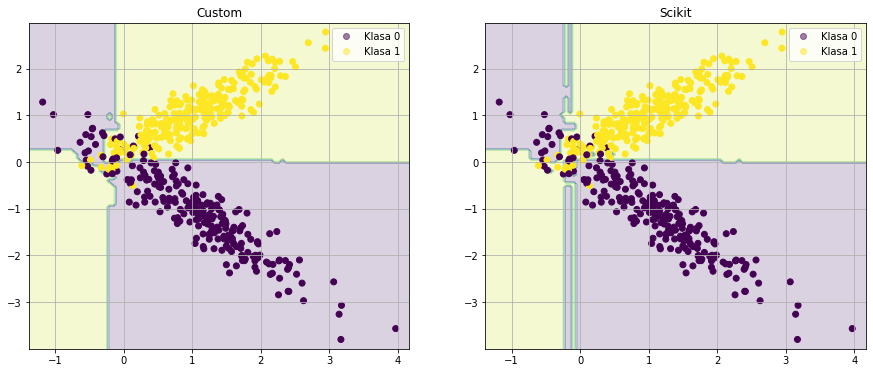

In [234]:
plot_classifiers(models_1, syn1_data['test'])

#### Macierz przekłamań

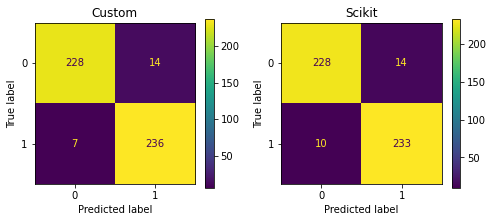

In [235]:
plot_confusion_matrixes(models_1, syn1_data['test'])

#### Metryki

In [236]:
show_models_metrics(models_1, syn1_data['test'])

,Sensitivity,Specificity,Accuracy,F1
Method,,,,
custom,0.9711934156378601,0.9421487603305785,0.9567010309278351,0.9574036511156186
scikit,0.9588477366255144,0.9421487603305785,0.9505154639175257,0.9510204081632653


#### Krzywa ROC

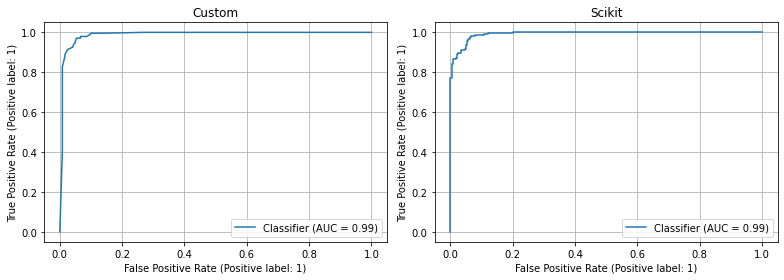

In [237]:
show_roc_curves(models_1, syn1_data['test'])

#### OOB Scores

Final OOB Score: 0.9425051334702258


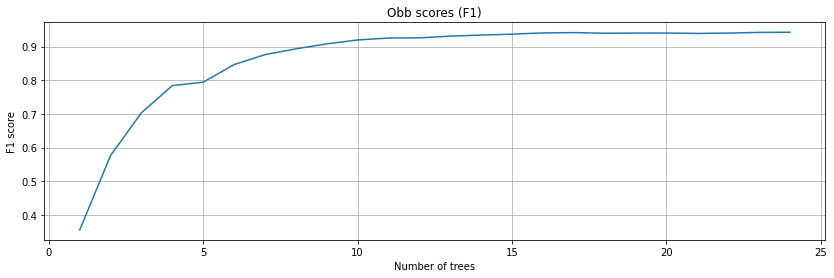

In [238]:
show_oob_scores(models_1[0])

#### Czasy

In [239]:
measure_times(models_1, syn1_data, n_fit=1, n_predict=1)

,Fit time,Predict time
Method,,
custom,6.029921200002718,0.1511430999962613
scikit,0.041950000006181654,0.002573300000221934


### b) Drugi zbiór - moons

#### Nauka

In [242]:
models_2 = train_classifiers(syn2_data, max_depth=6)

#### Powierzchnie decyzyjne

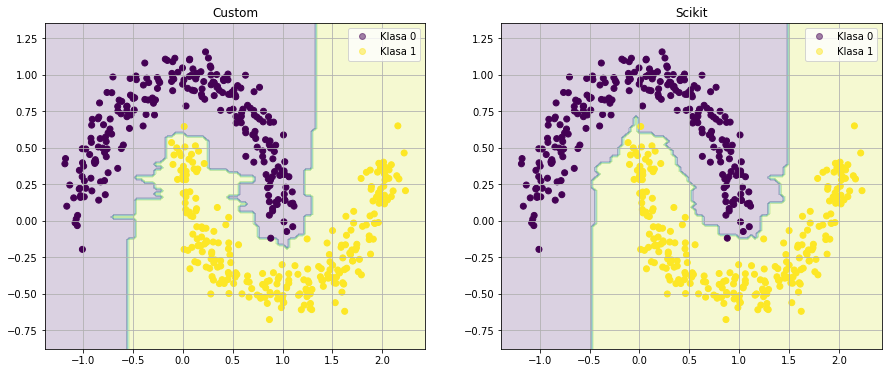

In [243]:
plot_classifiers(models_2, syn2_data['test'])

#### Macierz przekłamań

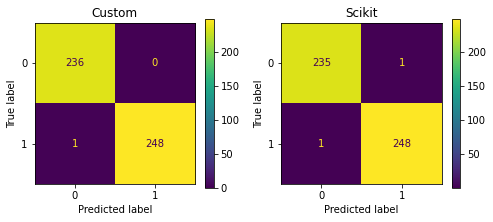

In [244]:
plot_confusion_matrixes(models_2, syn2_data['test'])

#### Metryki

In [245]:
show_models_metrics(models_2, syn2_data['test'])

,Sensitivity,Specificity,Accuracy,F1
Method,,,,
custom,0.9959839357429718,1.0,0.9979381443298969,0.9979879275653923
scikit,0.9959839357429718,0.9957627118644068,0.9958762886597938,0.9959839357429718


#### Krzywa ROC

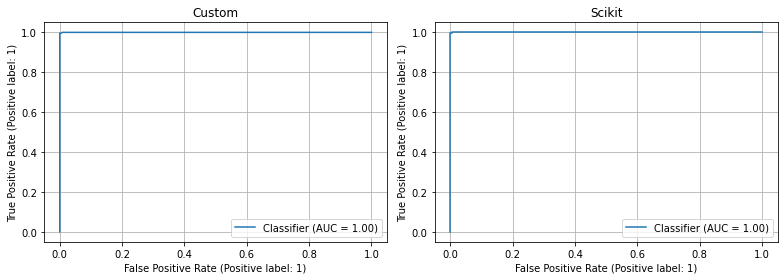

In [246]:
show_roc_curves(models_2, syn2_data['test'])

#### OOB Scores

Final OOB Score: 0.9879769994772609


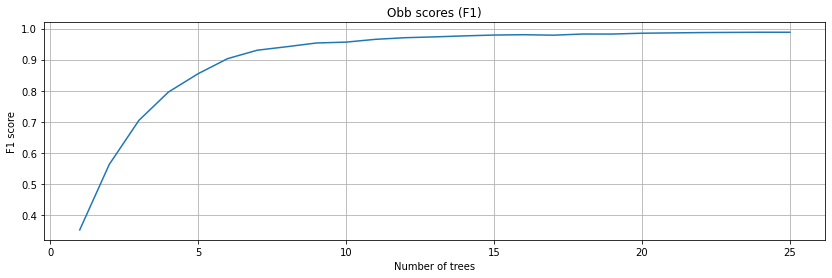

In [247]:
show_oob_scores(models_2[0])

#### Czasy

In [248]:
measure_times(models_2, syn2_data, n_fit=1, n_predict=1)

,Fit time,Predict time
Method,,
custom,5.286827299998549,0.11637799999880372
scikit,0.03527669999311911,0.0025300999986939132


### c) Trzeci zbiór - wielomodowy

#### Nauka

In [249]:
models_3 = train_classifiers(syn3_data, max_depth=8, max_samples=0.6)

#### Powierzchnie decyzyjne

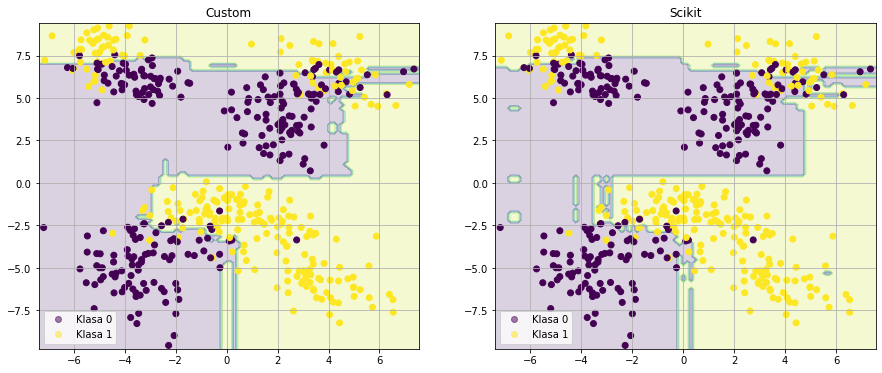

In [250]:
plot_classifiers(models_3, syn3_data['test'])

#### Macierz przekłamań

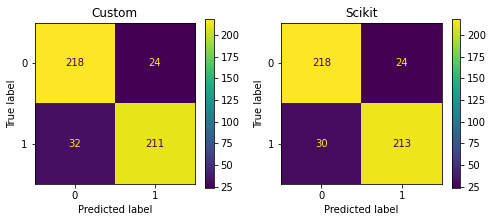

In [251]:
plot_confusion_matrixes(models_3, syn3_data['test'])

#### Metryki

In [252]:
show_models_metrics(models_3, syn3_data['test'])

,Sensitivity,Specificity,Accuracy,F1
Method,,,,
custom,0.8683127572016461,0.9008264462809917,0.8845360824742268,0.8828451882845187
scikit,0.8765432098765432,0.9008264462809917,0.8886597938144329,0.8875


#### Krzywa ROC

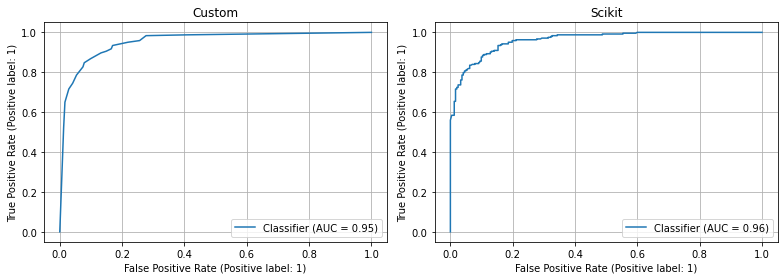

In [253]:
show_roc_curves(models_3, syn3_data['test'])

#### OOB Scores

Final OOB Score: 0.887257472469848


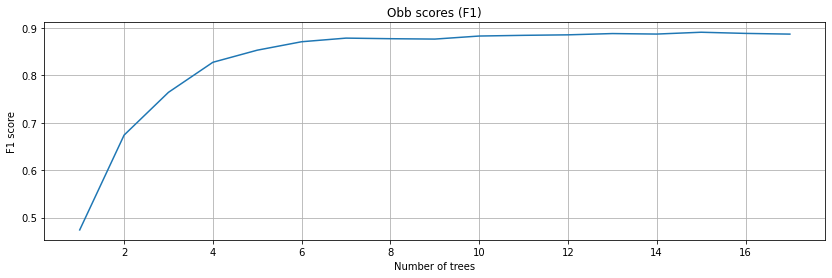

In [254]:
show_oob_scores(models_3[0])

#### Czasy

In [481]:
measure_times(models_3, syn3_data, n_fit=1, n_predict=1)

,Fit time,Predict time
Method,,
custom,9.036968400003389,0.13834610000048997
scikit,0.02502979999553645,0.002040100000158418


## Część II

### Przygotowanie danych

In [19]:
# Wczytywanie
nasa_data = pd.read_csv('NASA_JPL_asteroid.csv', low_memory=False)
nasa_data = nasa_data.astype({'epoch_mjd': 'float64'})
pd.set_option('display.max_columns', None)

In [20]:
# Usunięcie pustych kolumn
nan_percent = nasa_data.isna().sum() / len(nasa_data)
columns_to_drop = nan_percent.where(lambda x: x > 0.3).dropna().index.to_list()
nasa_data.drop(columns_to_drop, axis='columns', inplace=True)

print('Dropped columns:', columns_to_drop)

Dropped columns: ['name', 'prefix', 'diameter', 'albedo', 'diameter_sigma']


In [21]:
# Liczba unikatów i duplikatów w kolumnach kategorialnych
categorical_columns = ['id', 'spkid', 'full_name', 'pdes', 'orbit_id', 'equinox', 'neo', 'pha', 'class']
for column in categorical_columns:
    unique_count = len(nasa_data[column].unique())
    total_count = len(nasa_data)
    duplicate_count = total_count - unique_count
    print(f'{column:<11} Unique:{unique_count:10} Duplicates:{duplicate_count:10}')

id          Unique:    958524 Duplicates:         0
spkid       Unique:    958524 Duplicates:         0
full_name   Unique:    958524 Duplicates:         0
pdes        Unique:    958524 Duplicates:         0
orbit_id    Unique:      4690 Duplicates:    953834
equinox     Unique:         1 Duplicates:    958523
neo         Unique:         3 Duplicates:    958521
pha         Unique:         3 Duplicates:    958521
class       Unique:        13 Duplicates:    958511


In [22]:
# Usunięcie zbędnych kolumn
nasa_data.drop(columns=['id', 'spkid', 'full_name', 'pdes', 'orbit_id', 'equinox'], inplace=True)

In [23]:
# Zmiana T/N na 1/0
nasa_data.neo = nasa_data.neo.map({'Y': 1, 'N': 0})
nasa_data.pha = nasa_data.pha.map({'Y': 1, 'N': 0})

In [24]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

categorical_imputer = SimpleImputer(strategy='most_frequent')
continuous_imputer = SimpleImputer(strategy='mean')

categorical_vars = ['neo', 'pha', 'class']
continuous_vars = list(set(nasa_data.columns) - set(categorical_vars))

# transformer do imputacji
imputer = ColumnTransformer([
        ('categorical', categorical_imputer, categorical_vars),
        ('continuous', continuous_imputer, continuous_vars),
    ], remainder='passthrough')

# transformer onehot
onehot_encoder = ColumnTransformer([
        ('target', 'passthrough', [0, 1]),
        ('class', OneHotEncoder(), [2]),
    ], remainder='passthrough')

# finalny transformer
preprocessor = Pipeline([
    ('impute', imputer),
    ('onehot', onehot_encoder),
])

# proprocessing
nasa_data_pre = preprocessor.fit_transform(nasa_data).astype(np.float32)

### a) Detekcja NEO

In [25]:
# Usunięcie wierszy z brakującym neo
missing = nasa_data.neo.isna()
nasa_data_pre_neo = nasa_data_pre[~missing, :]
print(f'Usunięto {missing.sum()} wiersze')

Usunięto 4 wiersze


In [26]:
# Oddzielenie kolumny przewidywanej i cech
nasa_neo_x = np.delete(nasa_data_pre_neo, 0, axis=1)
nasa_neo_y = nasa_data_pre_neo[:, 0]

In [27]:
# Podział na zbiory
train_neo_x, test_neo_x, train_neo_y, test_neo_y = train_test_split(
    nasa_neo_x, nasa_neo_y,
    test_size=.2,
    random_state=seed,
    stratify=nasa_neo_y,
)

nasa_neo = {
    'train': {
        'x': train_neo_x,
        'y': train_neo_y,
    },
    'test': {
        'x': test_neo_x,
        'y': test_neo_y,
    }
}

#### Nauka

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from time import time

nasa_neo_model = RandomForestClassifier(random_state=seed)

param_grid = {
    # 'n_estimators': [100],
    # 'max_depth': [10],
    'n_estimators': [5, 10, 20, 50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 10, 15, 20],
    'min_samples_split': [2, 10, 20, 40],
    'min_samples_leaf': [1, 3, 8, 15],
}

nasa_neo_search = GridSearchCV(nasa_neo_model, param_grid, scoring='balanced_accuracy', cv=3, n_jobs=-1, verbose=1)

start = time()
nasa_neo_search.fit(nasa_neo['train']['x'], nasa_neo['train']['y']);
minutes = (time()-start) / 60
print(f'Fit time: {minutes:.2f} minutes')

Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Fit time: 121.18 minutes


In [113]:
nasa_neo_search.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10}

In [123]:
import joblib
joblib.dump(nasa_neo_model, 'nasa_neo_model.joblib')

['nasa_neo_model.joblib']

#### Macierz przekłamań

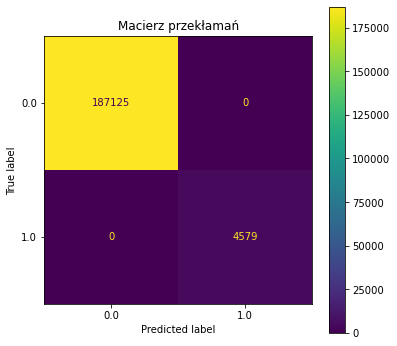

In [114]:
from sklearn.metrics import ConfusionMatrixDisplay

data = nasa_neo['test']
fig, ax = plt.subplots(figsize=(6, 6))

ConfusionMatrixDisplay.from_estimator(nasa_neo_search, data['x'], data['y'], ax=ax)
ax.set_title('Macierz przekłamań');

#### Metryki

In [115]:
from sklearn.metrics import recall_score, f1_score

# Obliczanie metryk
data = nasa_neo['test']

predictions = nasa_neo_search.predict(data['x'])

sens = recall_score(data['y'], predictions)
spec = recall_score(data['y'], predictions, pos_label=0)
f1 = f1_score(data['y'], predictions)

# Tworzenie tabeli
pd.DataFrame({'Sensitivity': [sens], 'Specificity': [spec], 'F1': [f1]}, index=['Classifier'])

,Sensitivity,Specificity,F1
Classifier,1.0,1.0,1.0


#### Krzywa ROC

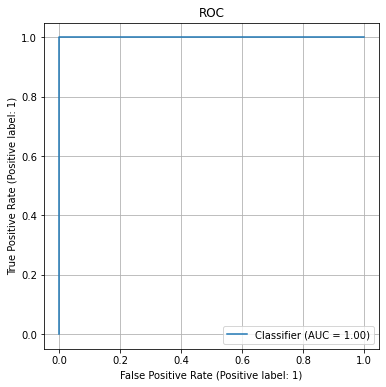

In [116]:
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_predict

data = nasa_neo['train']
fig, ax = plt.subplots(figsize=(6, 6))

predictions_c = nasa_neo_search.predict_proba(data['x'])[:, 1]
RocCurveDisplay.from_predictions(data['y'], predictions_c, ax=ax)
ax.set_title('ROC')
ax.grid();

#### Czasy

In [117]:
measure_models_times({'model': nasa_neo_model}, data=nasa_neo, n_fit=1, n_predict=1)

,Fit time,Predict time
model,148.97839649999514,0.986923399999796


### b) Detekcja PHA

In [107]:
# Usunięcie wierszy z brakującym pha
missing = nasa_data.pha.isna()
nasa_data_pre_pha = nasa_data_pre[~missing, :]
print(f'Usunięto {missing.sum()} wiersze')

Usunięto 19921 wiersze


In [108]:
# Oddzielenie kolumny przewidywanej i cech
nasa_pha_x = np.delete(nasa_data_pre_pha, 1, axis=1)
nasa_pha_y = nasa_data_pre_pha[:, 1]

In [109]:
# Podział na zbiory
train_pha_x, test_pha_x, train_pha_y, test_pha_y = train_test_split(
    nasa_pha_x, nasa_pha_y,
    test_size=.2,
    random_state=seed,
    stratify=nasa_pha_y
)

# Strukturyzacja
nasa_pha = {
    'train': {
        'x': train_pha_x,
        'y': train_pha_y,
    },
    'test': {
        'x': test_pha_x,
        'y': test_pha_y,
    }
}

#### Nauka

In [112]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from time import time

nasa_pha_model = RandomForestClassifier(random_state=seed)

param_grid = {
    # 'n_estimators': [1],
    # 'max_depth': [1],
    'n_estimators': [5, 10, 20, 50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 10, 15, 20],
    'min_samples_split': [2, 10, 20, 40],
    'min_samples_leaf': [1, 3, 8, 15],
}

nasa_pha_search = GridSearchCV(nasa_pha_model, param_grid, scoring='balanced_accuracy', cv=3, n_jobs=-1, verbose=1)

start = time()
nasa_pha_search.fit(nasa_pha['train']['x'], nasa_pha['train']['y']);
minutes = (time()-start) / 60
print(f'Fit time: {minutes:.5f} minutes')

Fitting 3 folds for each of 768 candidates, totalling 2304 fits
Fit time: 94.86357 minutes


In [118]:
nasa_pha_search.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 50}

In [124]:
import joblib
joblib.dump(nasa_pha_model, 'nasa_pha_model.joblib')

['nasa_pha_model.joblib']

#### Macierz przekłamań

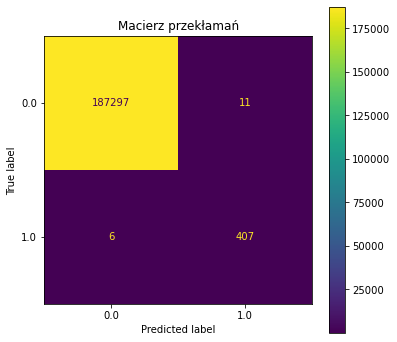

In [119]:
from sklearn.metrics import ConfusionMatrixDisplay

data = nasa_pha['test']
fig, ax = plt.subplots(figsize=(6, 6))

ConfusionMatrixDisplay.from_estimator(nasa_pha_search, data['x'], data['y'], ax=ax)
ax.set_title('Macierz przekłamań');

#### Metryki

In [120]:
from sklearn.metrics import recall_score, f1_score

# Obliczanie metryk
data = nasa_pha['test']

predictions = nasa_pha_search.predict(data['x'])

sens = recall_score(data['y'], predictions)
spec = recall_score(data['y'], predictions, pos_label=0)
f1 = f1_score(data['y'], predictions)

# Tworzenie tabeli
pd.DataFrame({'Sensitivity': [sens], 'Specificity': [spec], 'F1': [f1]}, index=['Classifier'])

,Sensitivity,Specificity,F1
Classifier,0.985472,0.999941,0.979543


#### Krzywa ROC

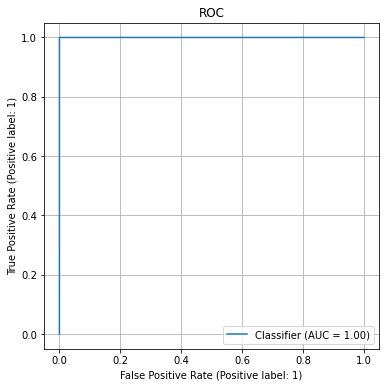

In [121]:
from sklearn.metrics import RocCurveDisplay

data = nasa_pha['train']
fig, ax = plt.subplots(figsize=(6, 6))

predictions_c = nasa_pha_search.predict_proba(data['x'])[:, 1]
RocCurveDisplay.from_predictions(data['y'], predictions_c, ax=ax)
ax.set_title('ROC')
ax.grid();

#### Czasy

In [122]:
measure_models_times({'model': nasa_pha_model}, data=nasa_pha, n_fit=1, n_predict=10)

,Fit time,Predict time
model,97.71515779999754,0.9550012299994706


### c) Porównanie hiperparametrów

|                   | NEO  | PHA  |
|-------------------|------|------|
| criterion         | gini | gini |
| max_depth         | 5    | 15   |
| n_estimators      | 10   | 50   |
| min_samples_leaf  | 1    | 3    |
| min_samples_split | 2    | 10   |

Znalezione optymalne hiperparametry różnią się dla obu problemów

## Część III

### Zbieranie pomiarów

In [65]:
import contextlib
import joblib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [67]:
from joblib import Parallel, delayed
from random import shuffle
from sklearn.base import clone
from time import time
from sklearn.metrics import recall_score, f1_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier


def train_single_model(method, depth):
    
    data = nasa_neo
    
    models = {
        'custom': CustomRandomForestClassifier(n_estimators=40, max_depth=depth, oob_score=None),
        'scikit': RandomForestClassifier(n_estimators=40, max_depth=depth),
    }
    model = models[method]

    fit_start = time()
    model.fit(data['train']['x'], data['train']['y'])
    fit_time = time() - fit_start

    predict_start = time()
    predictions = model.predict(data['test']['x'])
    predict_time = time() - predict_start

    f1 = f1_score(data['test']['y'], predictions)
    acc = balanced_accuracy_score(data['test']['y'], predictions)

    return {'method': method, 'depth': depth, 'fit': fit_time, 'predict': predict_time, 'f1': f1, 'acc': acc}


def get_measures(depths, repeats):
    tasks = []
    for depth in depths:
        for method in ['custom', 'scikit']:
            for repeat in range(repeats):
                task = delayed(train_single_model)(method, depth)
                tasks.append(task)
    shuffle(tasks)
    
    results = None
    with tqdm_joblib(tqdm(desc='Measures', total=len(tasks))) as progress_bar:
        results = Parallel(n_jobs=5)(tasks)
    
    groupped_results = {}
    for depth in depths:
        depth_results = {}
        groupped_results[depth] = depth_results
        for method in ['custom', 'scikit']:
            filtered_results = [res for res in results if res['method'] == method and res['depth'] == depth]
            fit = np.mean([res['fit'] for res in filtered_results])
            predict = np.mean([res['predict'] for res in filtered_results])
            f1 = np.mean([res['f1'] for res in filtered_results])
            acc = np.mean([res['acc'] for res in filtered_results])
            method_results = {'fit': fit, 'predict': predict, 'f1': f1, 'acc': acc}
            depth_results[method] = method_results
            
    return results, groupped_results

In [68]:
from time import time
measure_start = time()
tmp, measures = get_measures(depths=range(1, 16), repeats=5)
measure_time = time() - measure_start
print(f'Measure time: {measure_time / 60} minutes')

Measures: 100%|██████████████████████████████████████████████| 150/150 [5:52:34<00:00, 141.03s/it]

Measure time: 352.56918903589246 minutes


### Tabela wyników

In [75]:
records = []

for depth, depth_values in measures.items():
    for method, single_measure in depth_values.items():
        record_measures = (single_measure[key] for key in ('fit', 'predict', 'f1', 'acc'))
        record = (depth, method, *record_measures)
        records.append(record)

matrix = np.array(records)

df = pd.DataFrame({
    'Depth': matrix[:,0].astype(np.int32),
    'Method': matrix[:,1],
    'Fit time': matrix[:,2],
    'Predict time': matrix[:,3],
    'F1': matrix[:,4],
    'Balanced accuracy': matrix[:,5],
})

df = df.set_index(['Method', 'Depth']).sort_index()
df

Fit time        Predict time                  F1  \
Method Depth                                                               
custom 1       337.5947051048279   65.09587235450745  0.7266777213922936   
       2       621.0379467964173   86.52968354225159  0.9520799002209435   
       3       860.2011414527893  106.56620306968689  0.9872749077588056   
       4      1020.4078963756562   132.1989031791687  0.9994318133295115   
       5      1178.9282062530517   143.5742775917053                 1.0   
       6      1243.0101713180543  147.37778496742249                 1.0   
       7      1325.3838180541993  152.12740845680236                 1.0   
       8       1312.469246149063  155.63668403625488                 1.0   
       9      1325.2640141487122  161.52160177230834                 1.0   
       10     1307.8290292739869  142.21097021102906                 1.0   
       11     1388.1028244495392  164.89749984741212                 1.0   
       12     1435.2041989803315    164.892648601532                 1.0   
       13     1422.2073813915254  166.95724954605103                 1.0   
       14     1291.0171112060548  158.70899777412416                 1.0   
       15     1473.3062555789948  170.30644640922546                 1.0   
scikit 1      25.710031604766847  0.5738399982452392  0.7572545276227531   
       2      42.058268308639526   1.210591459274292  0.9877610456206831   
       3       53.46451296806335  0.6521523475646973  0.9981942108968637   
       4       73.32327837944031  0.6774319171905517  0.9994748739654001   
       5       82.45810022354127  1.0981399059295653                 1.0   
       6       86.94138007164001  0.6430491447448731                 1.0   
       7       80.14128851890564  0.6239929676055909                 1.0   
       8      100.33011245727539  0.6526566505432129                 1.0   
       9      103.55666952133178  0.9056553363800048                 1.0   
       10      86.61808338165284  0.6462377071380615                 1.0   
       11      95.64946126937866  0.6399136543273926                 1.0   
       12      95.91430683135987  1.3326137065887451                 1.0   
       13     103.68811678886414  0.6082192420959472                 1.0   
       14      96.59859523773193   0.634716272354126                 1.0   
       15      95.26216721534729  0.6790798664093017                 1.0   

               Balanced accuracy  
Method Depth                      
custom 1      0.7921816990609303  
       2      0.9543989209254938  
       3      0.9874639775000243  
       4      0.9994961037164961  
       5                     1.0  
       6                     1.0  
       7                     1.0  
       8                     1.0  
       9                     1.0  
       10                    1.0  
       11                    1.0  
       12                    1.0  
       13                    1.0  
       14                    1.0  
       15                    1.0  
scikit 1      0.8075705921853169  
       2      0.9883273770369595  
       3      0.9982518248406255  
       4      0.9994758680934701  
       5                     1.0  
       6                     1.0  
       7                     1.0  
       8                     1.0  
       9                     1.0  
       10                    1.0  
       11                    1.0  
       12                    1.0  
       13                    1.0  
       14                    1.0  
       15                    1.0

### Wykresy

In [70]:
import matplotlib.pyplot as plt

def plot_measure(measures, name, label):
    depths = np.array(list(measures.keys()))
    custom_measures = np.array([measures[depth]['custom'][name] for depth in depths])
    scikit_measures = np.array([measures[depth]['scikit'][name] for depth in depths])
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.plot(depths, custom_measures, label='Custom')
    ax.plot(depths, scikit_measures, label='Scikit')
    
    ax.set_title(label)
    ax.set_ylabel(label)
    ax.set_xlabel('Depth')
    ax.grid()
    ax.set_xlim([1, depths[-1]])
    ax.legend()

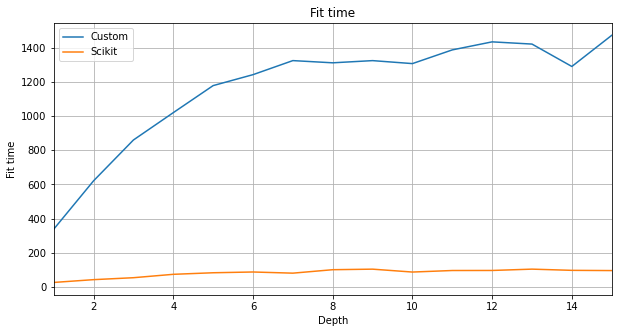

In [71]:
plot_measure(measures, 'fit', 'Fit time')

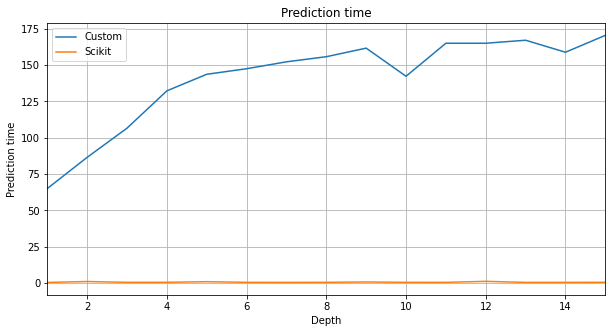

In [72]:
plot_measure(measures, 'predict', 'Prediction time')

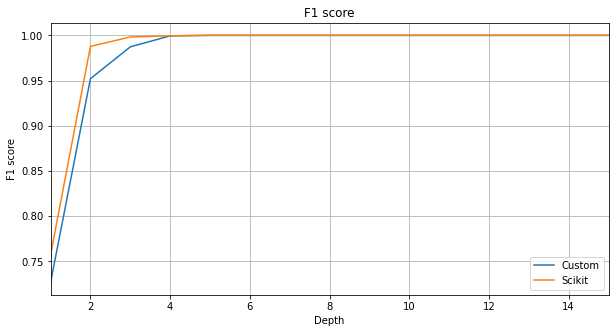

In [73]:
plot_measure(measures, 'f1', 'F1 score')

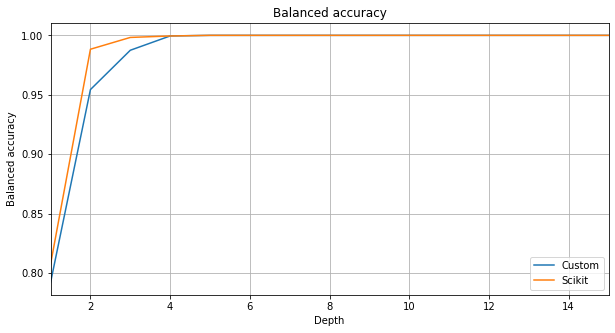

In [74]:
plot_measure(measures, 'acc', 'Balanced accuracy')